# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

print(os.getcwd())

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


c:\Users\user\Documents\research\BMCA-pipeline\notebooks\all_data


In [2]:
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/all_data/')

# Perturbing enzymes

In [4]:
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_yeast.ant' 
data_file = '../../data/interim/generated_data/Simplified_Teusink_yeast_2.0.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.5710734600032811e-15

In [5]:
BMCA_obj = BMCA.BMCA(Teusink_ant, data_file)
# BMCA_obj_15 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv')
# BMCA_obj_15_1000 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts-1000.csv')

Model does not contain SBML fbc package information.


../../data/interim/Antimony/Simplified_Teusink_yeast_cobra.ant
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,116.3


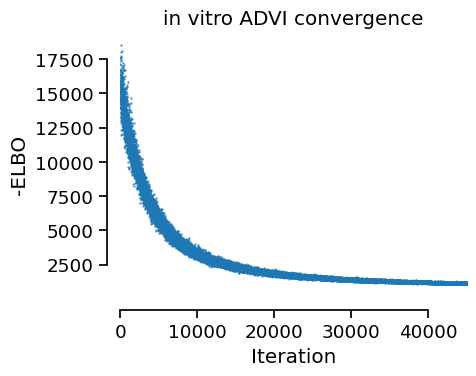

In [6]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)

trace_ADVI = run_ADVI(BMCA_obj)

In [7]:
Ex_advi = (trace_ADVI['posterior']['Ex']).to_numpy().squeeze()
Ey_advi = (trace_ADVI['posterior']['Ey']).to_numpy().squeeze()

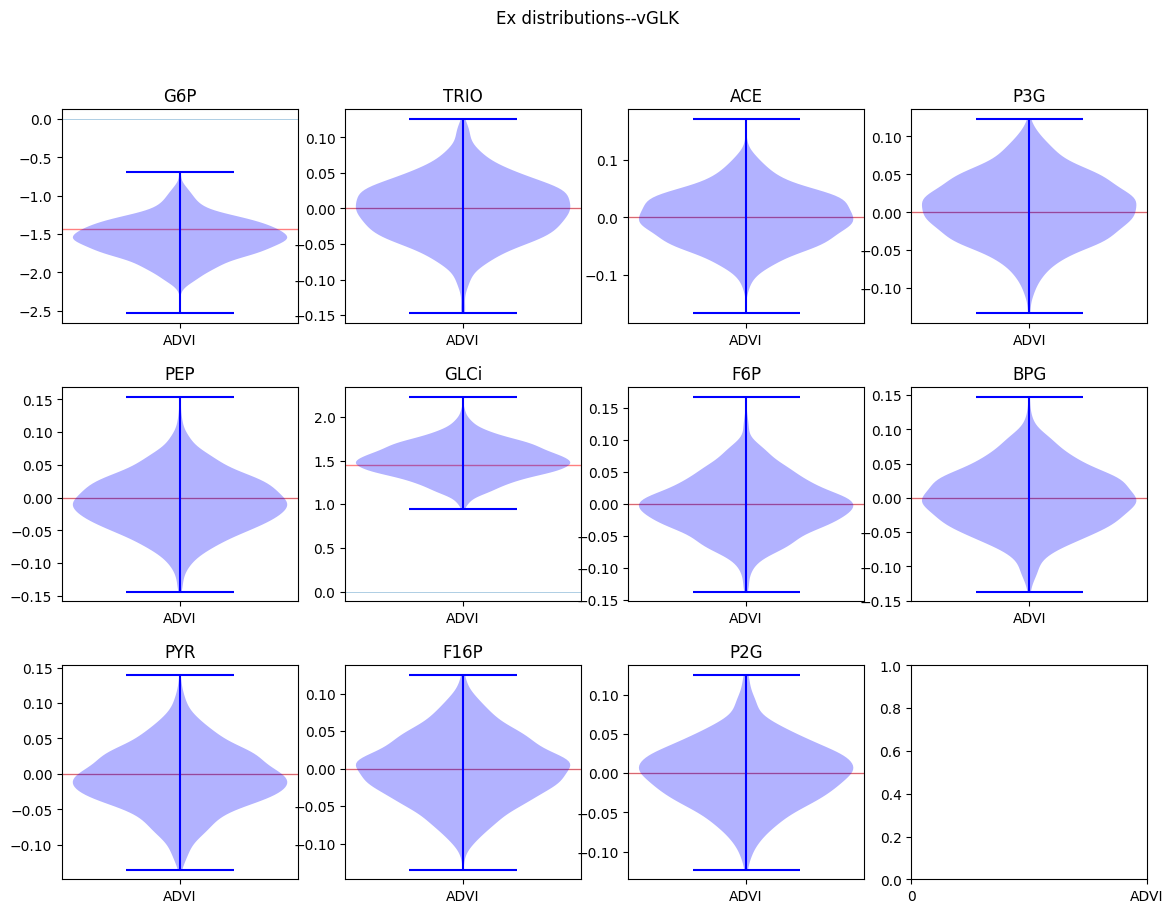

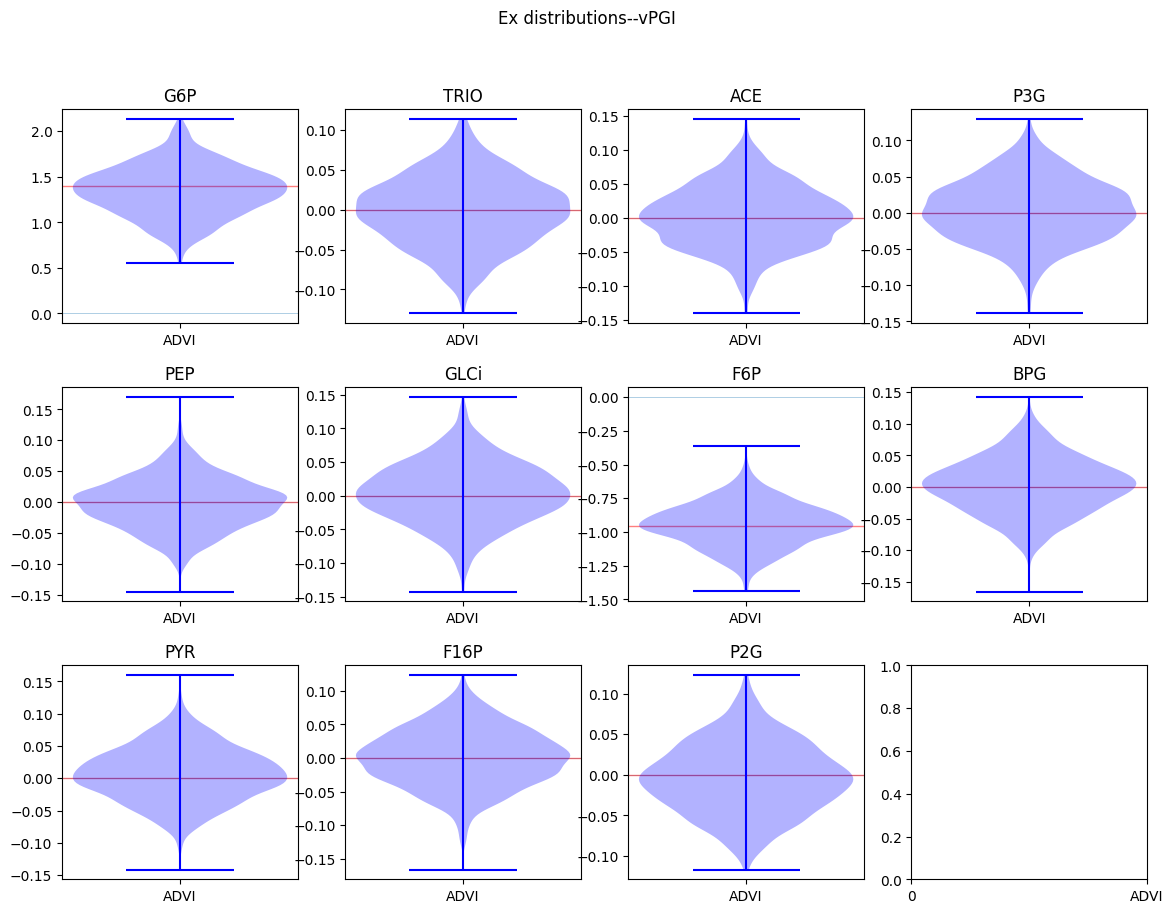

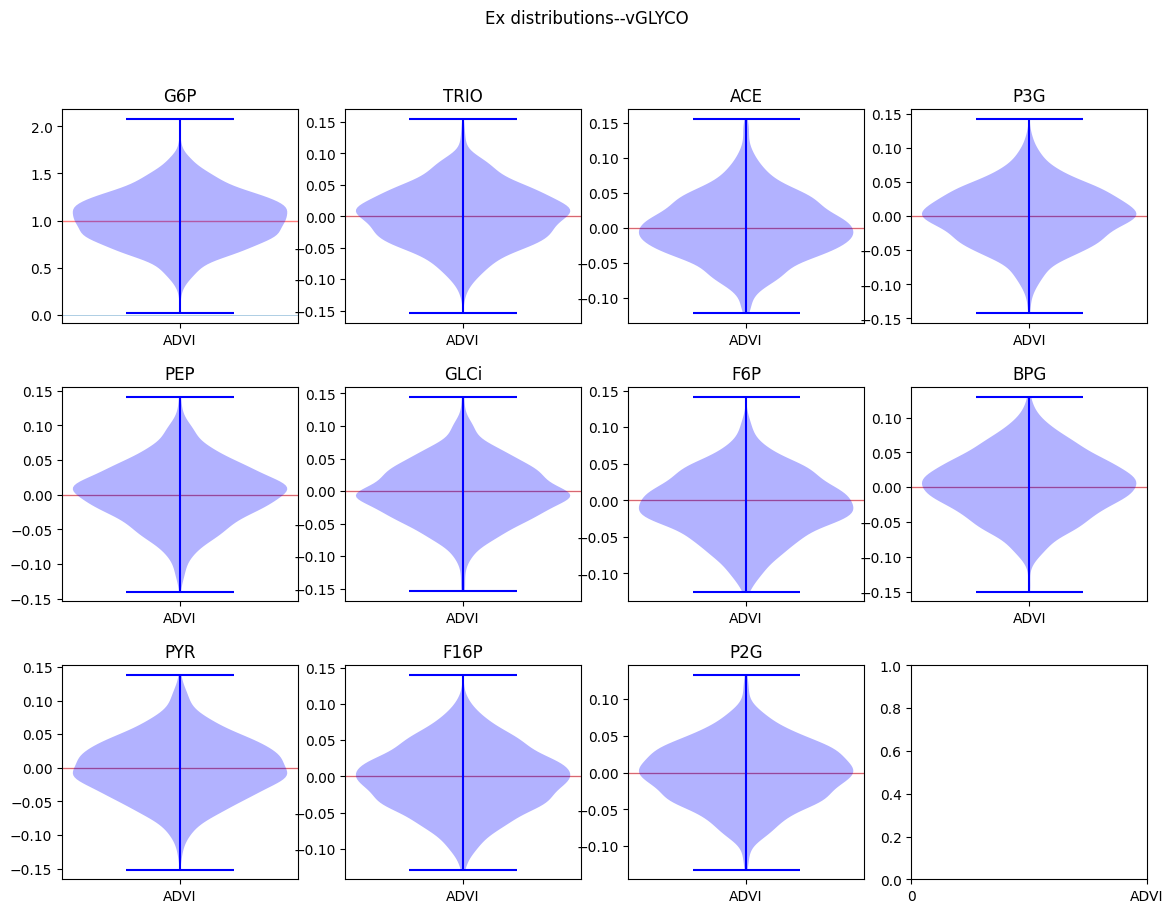

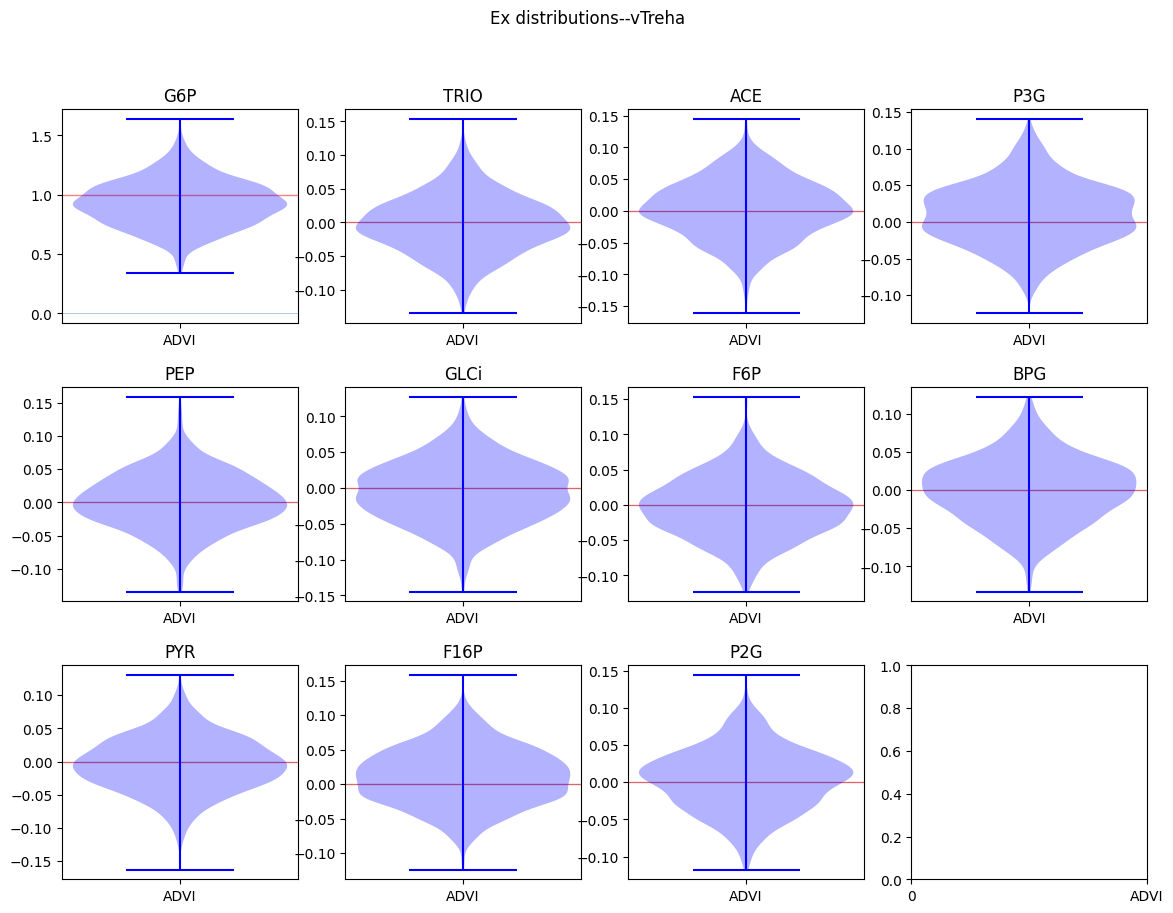

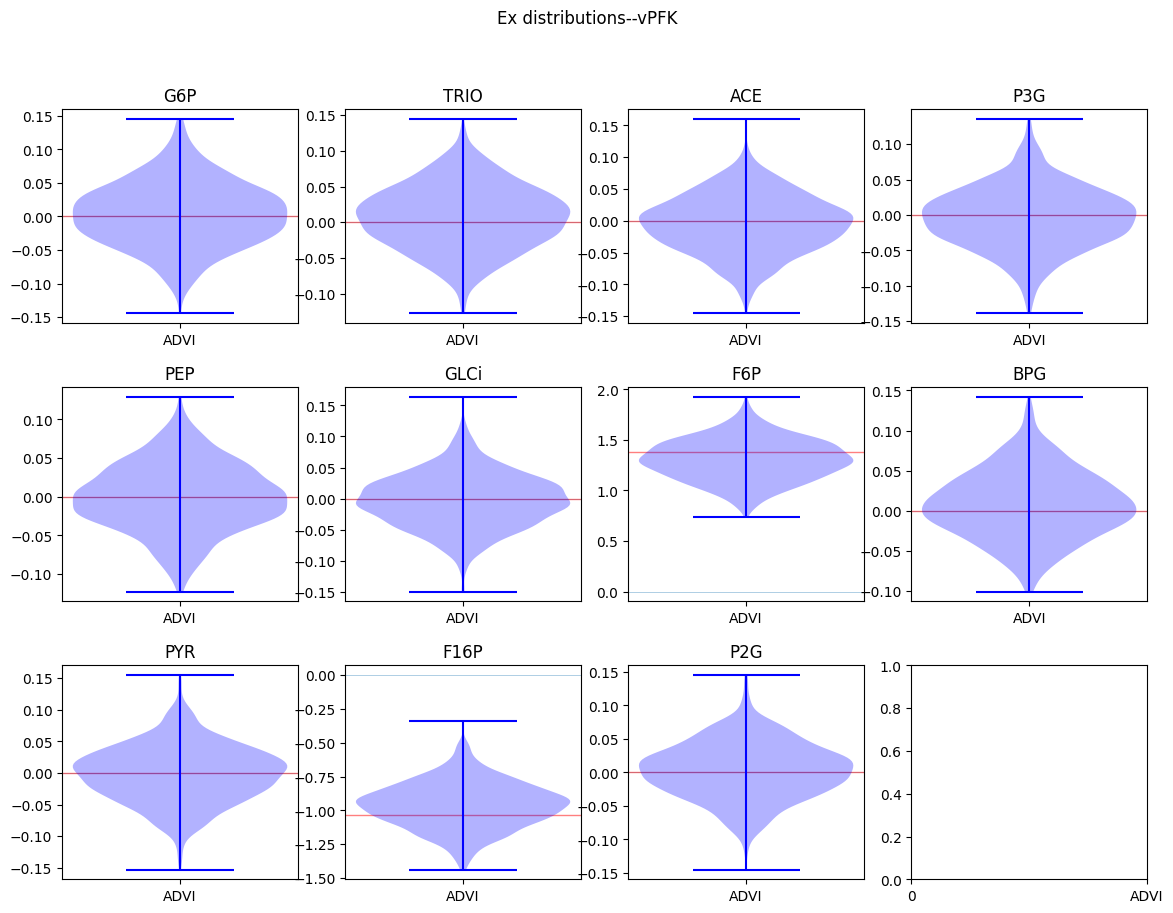

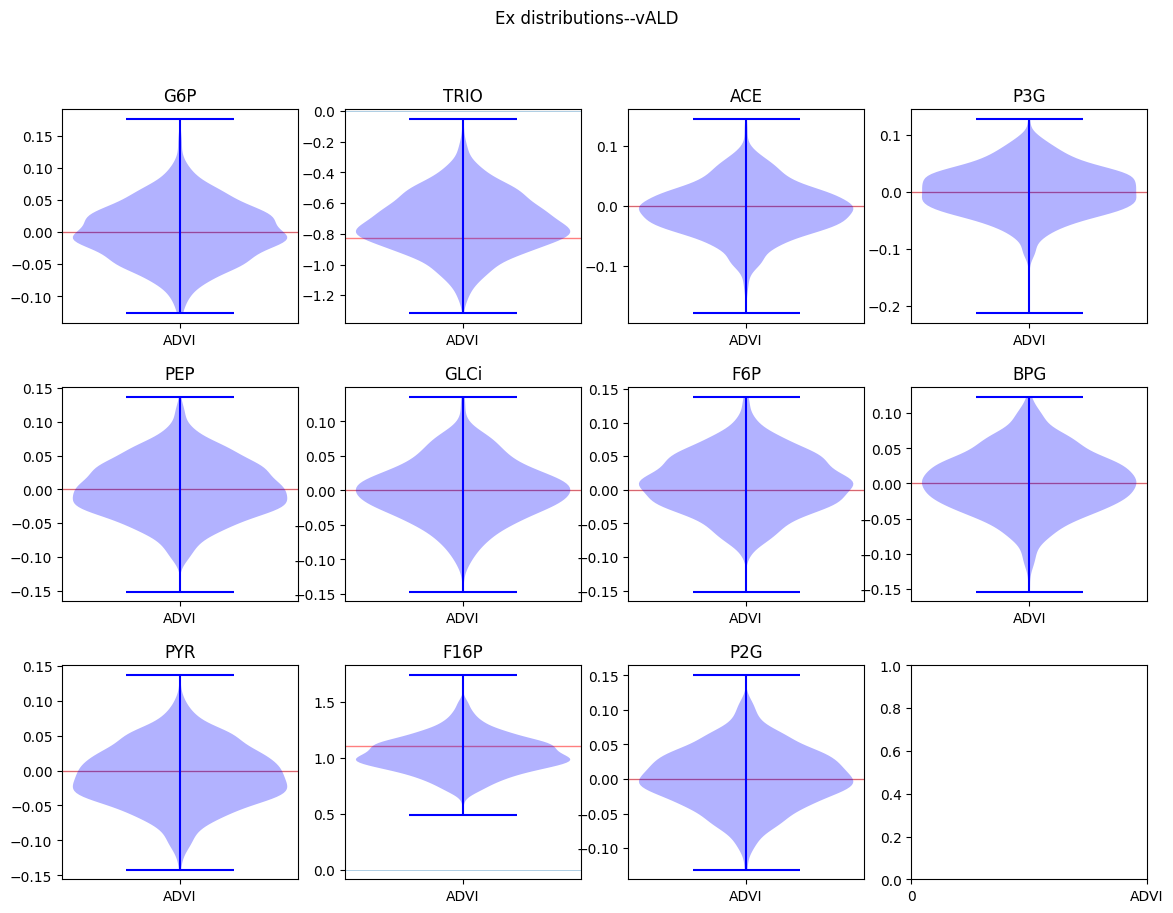

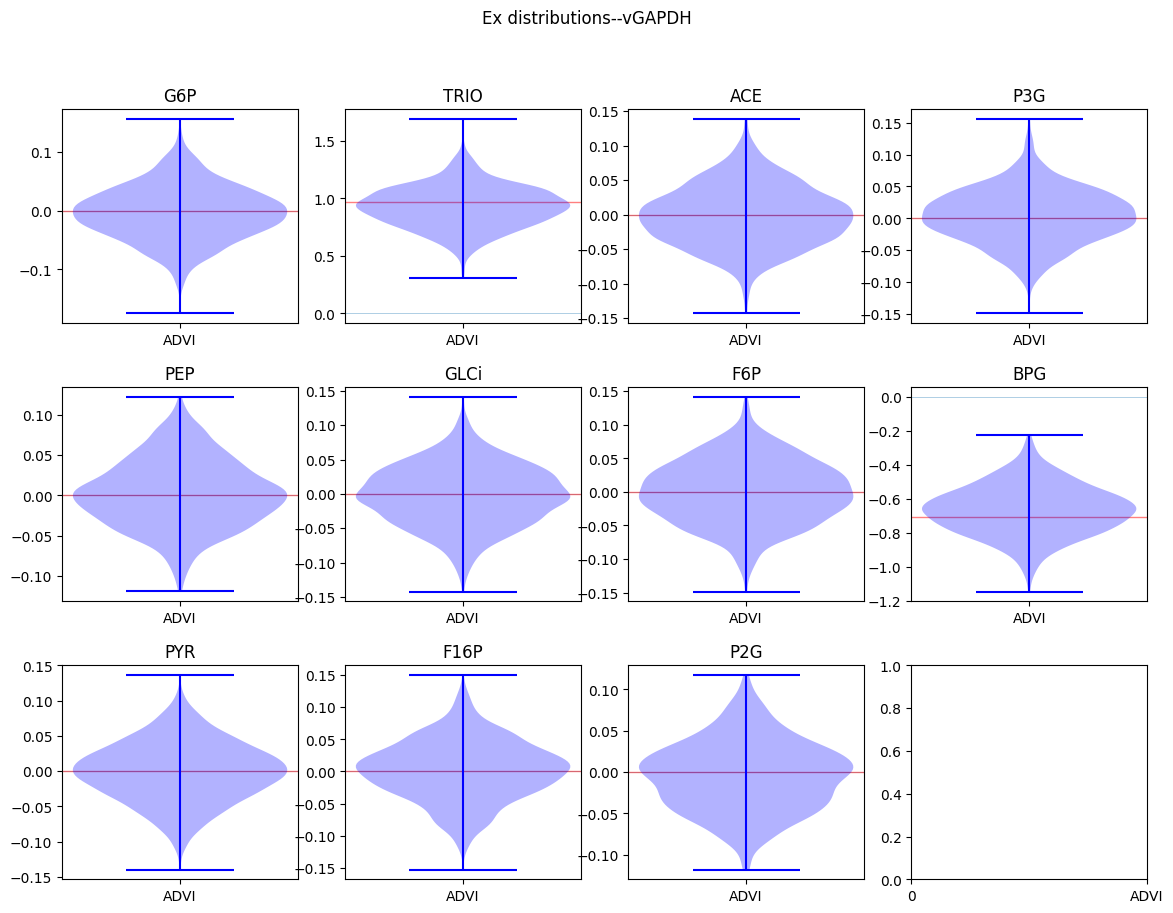

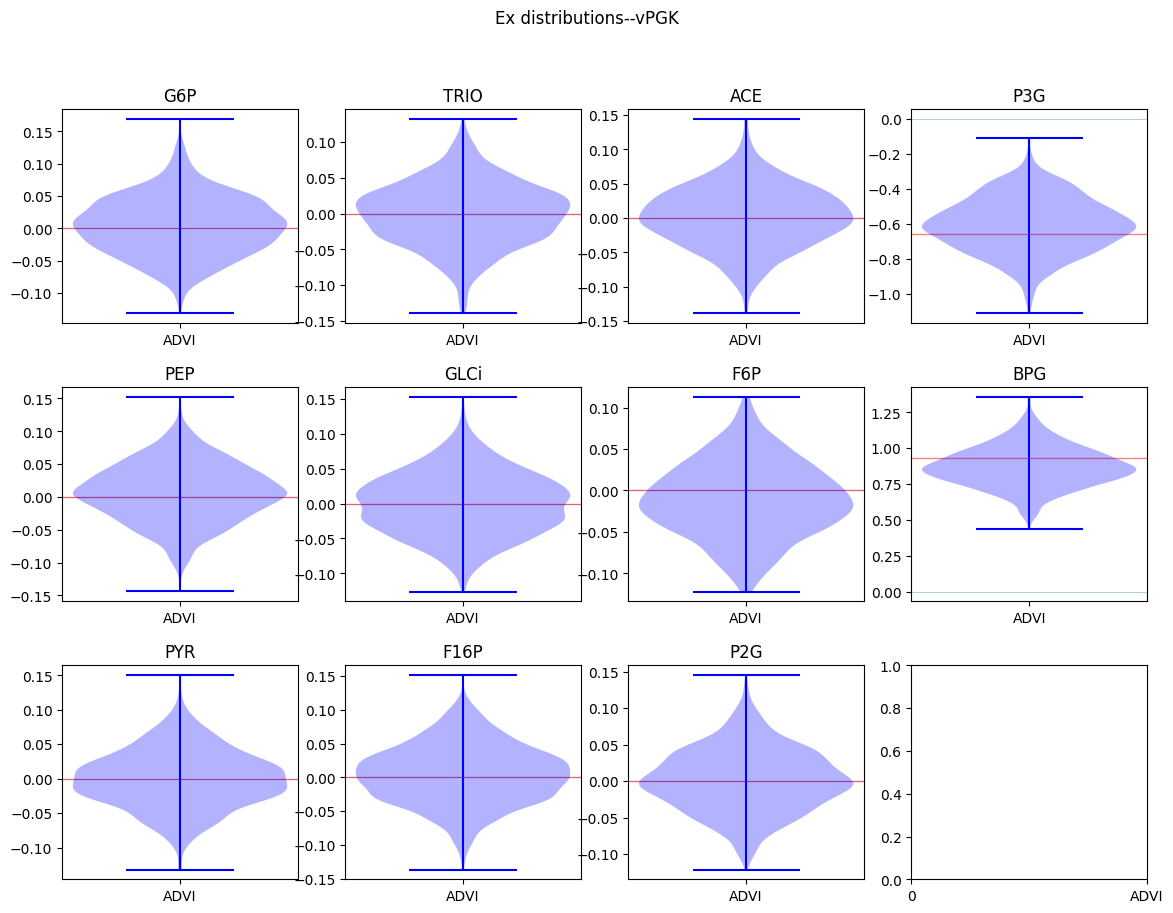

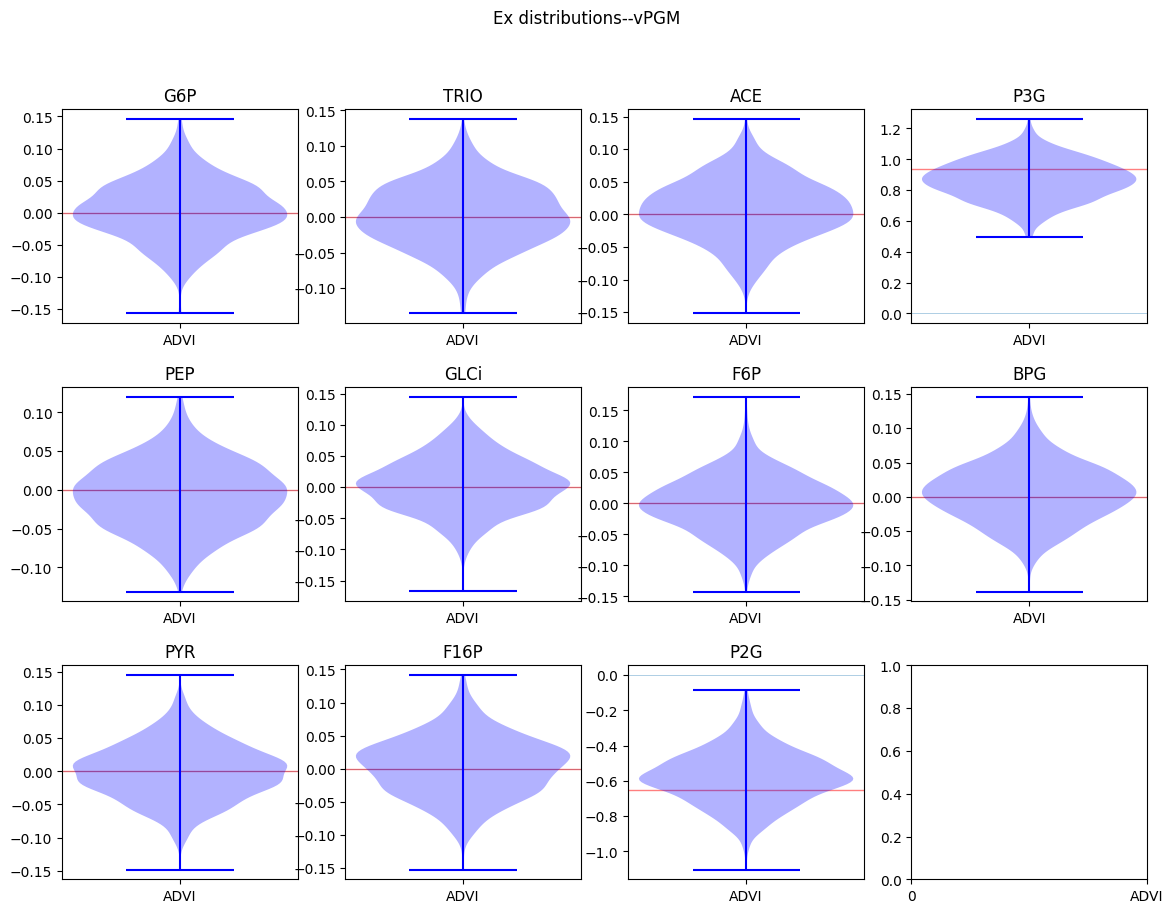

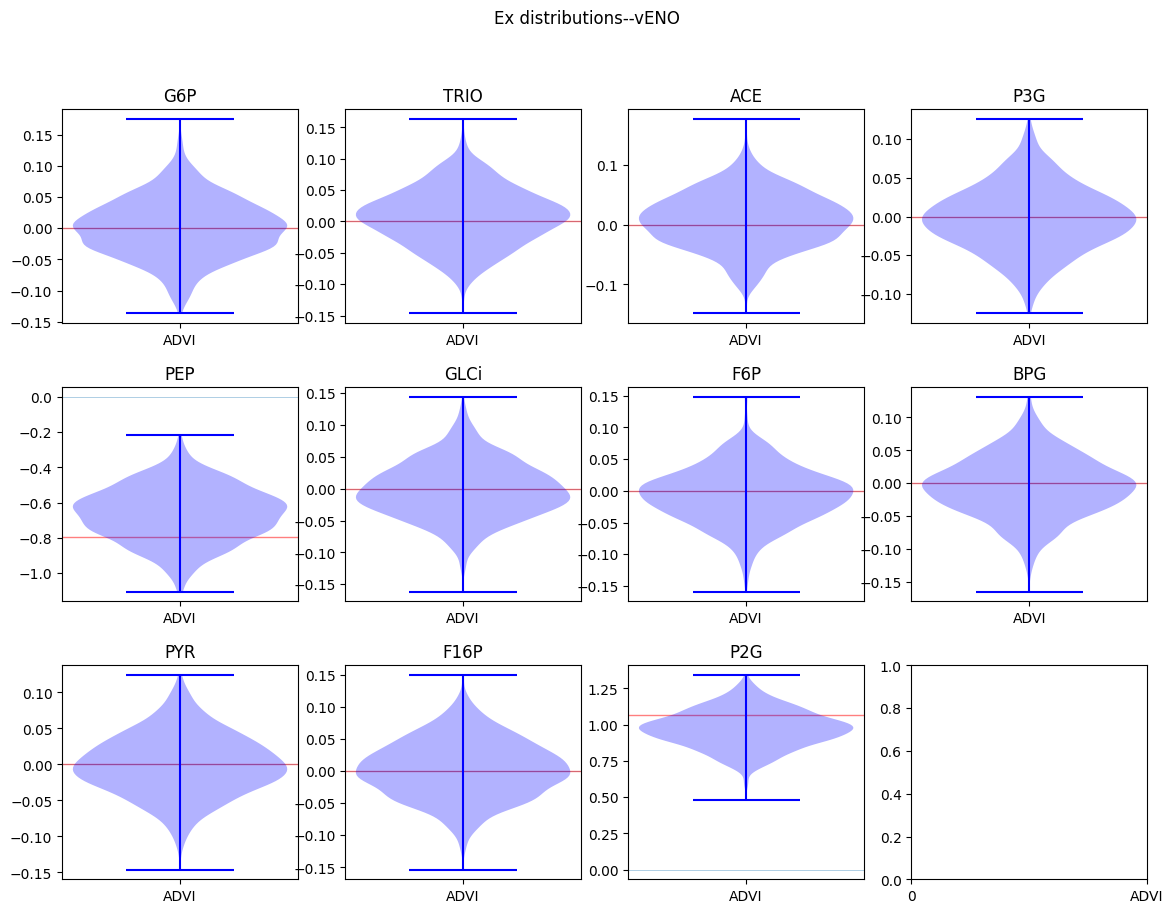

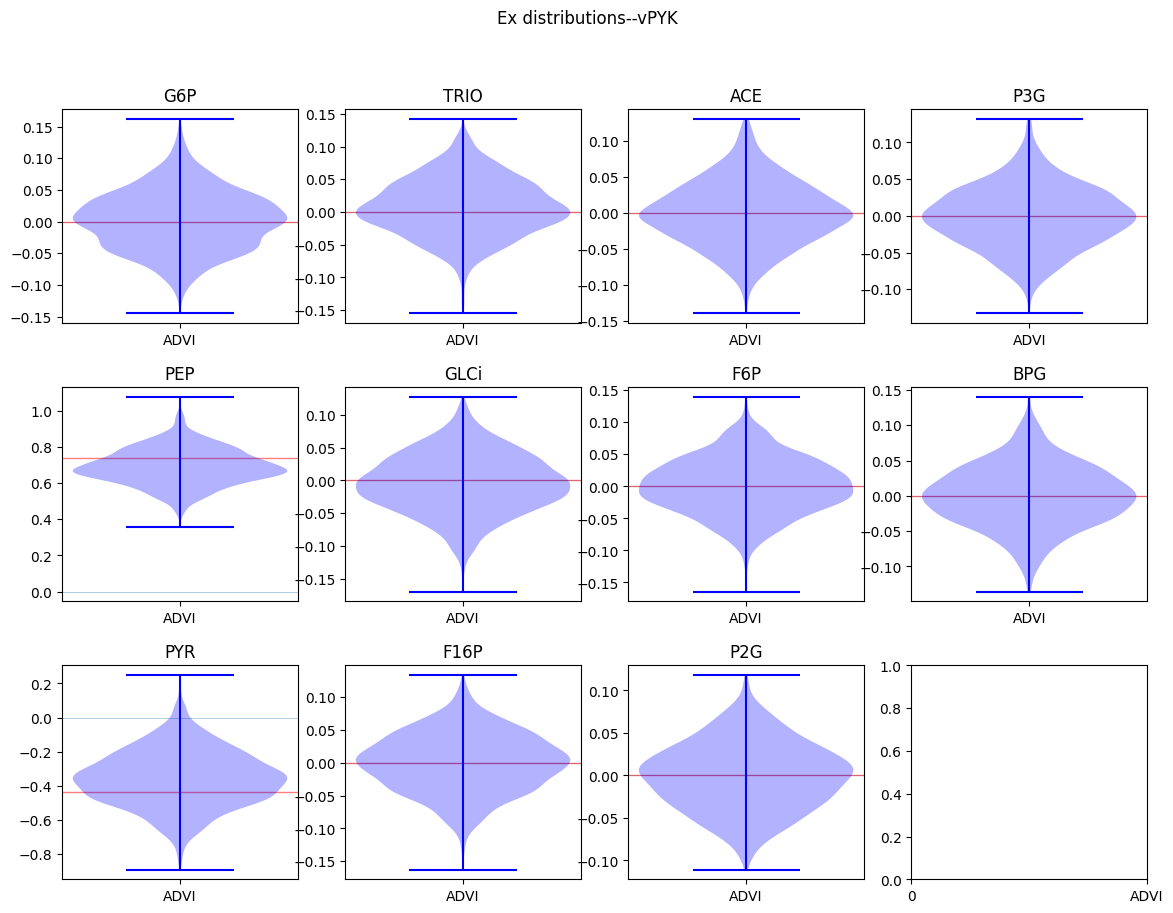

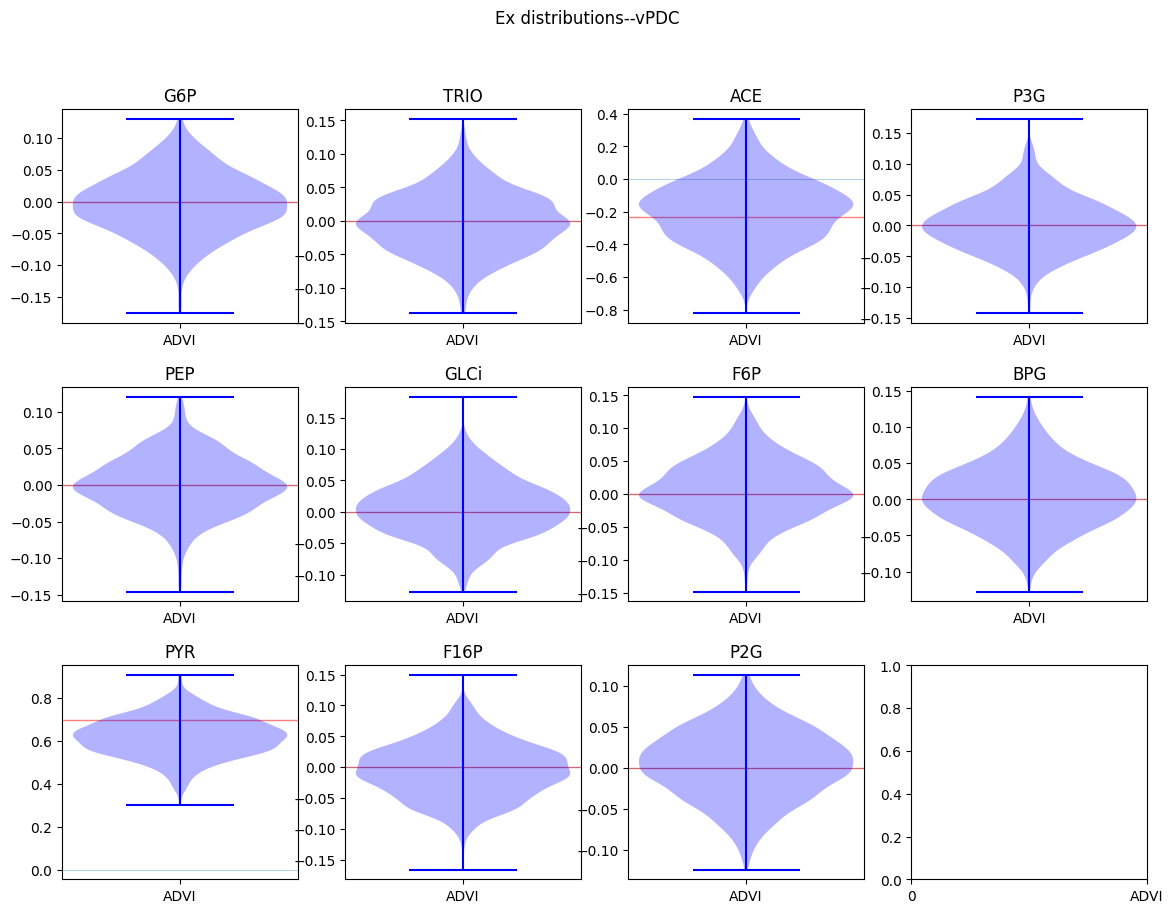

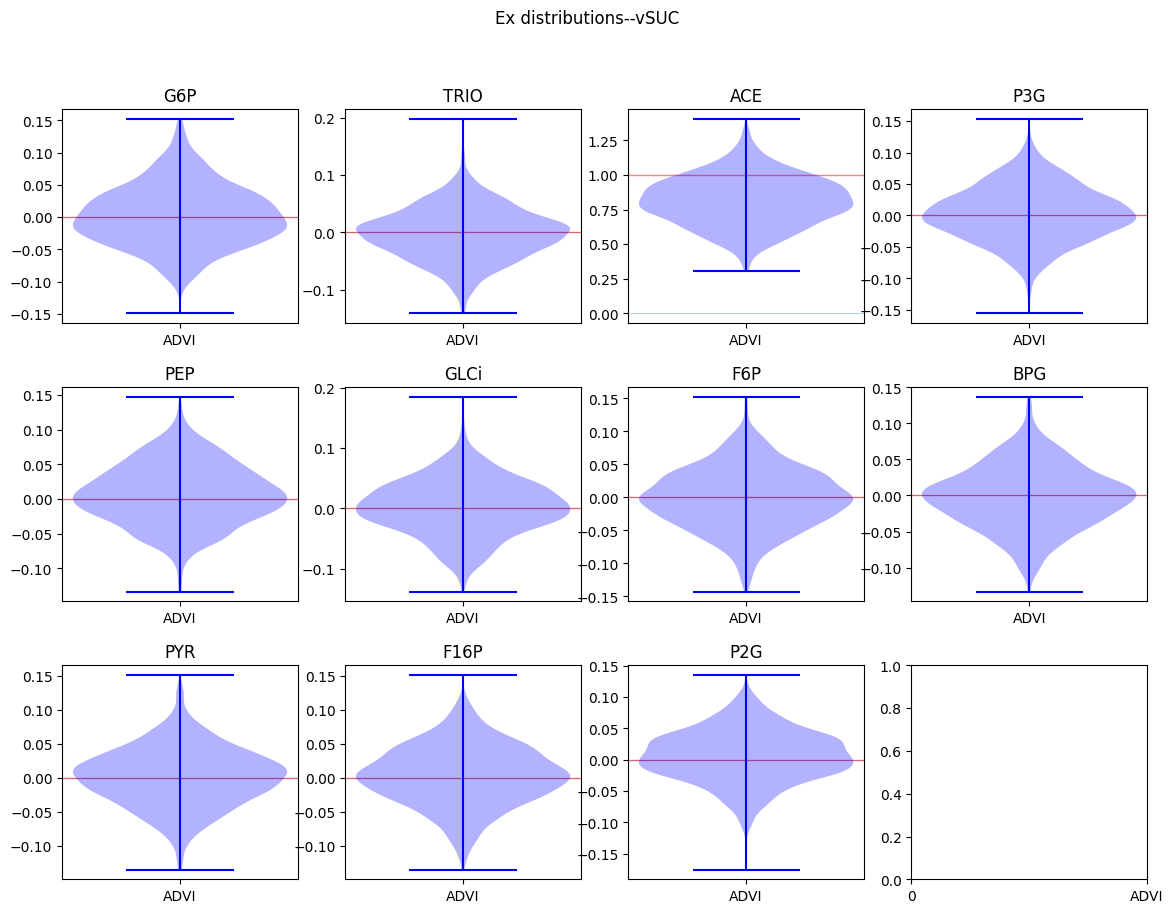

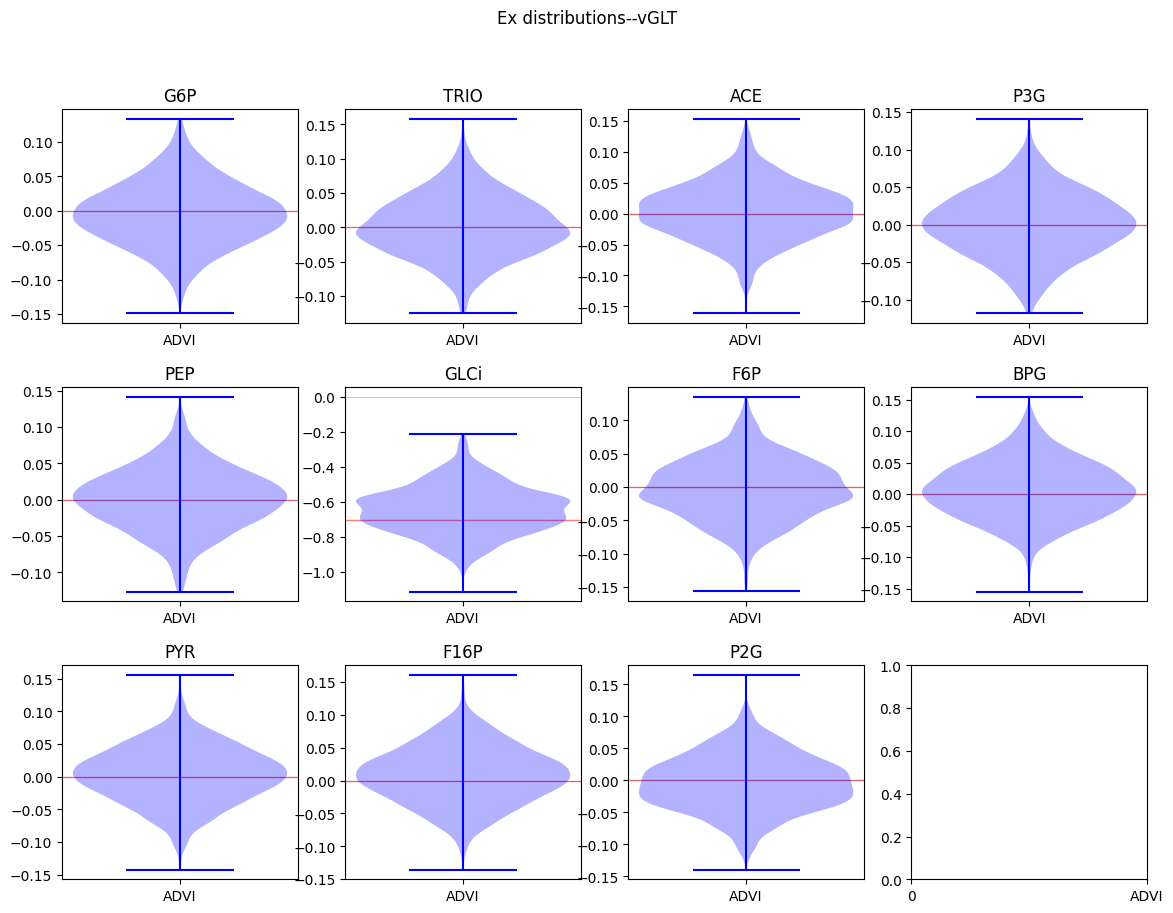

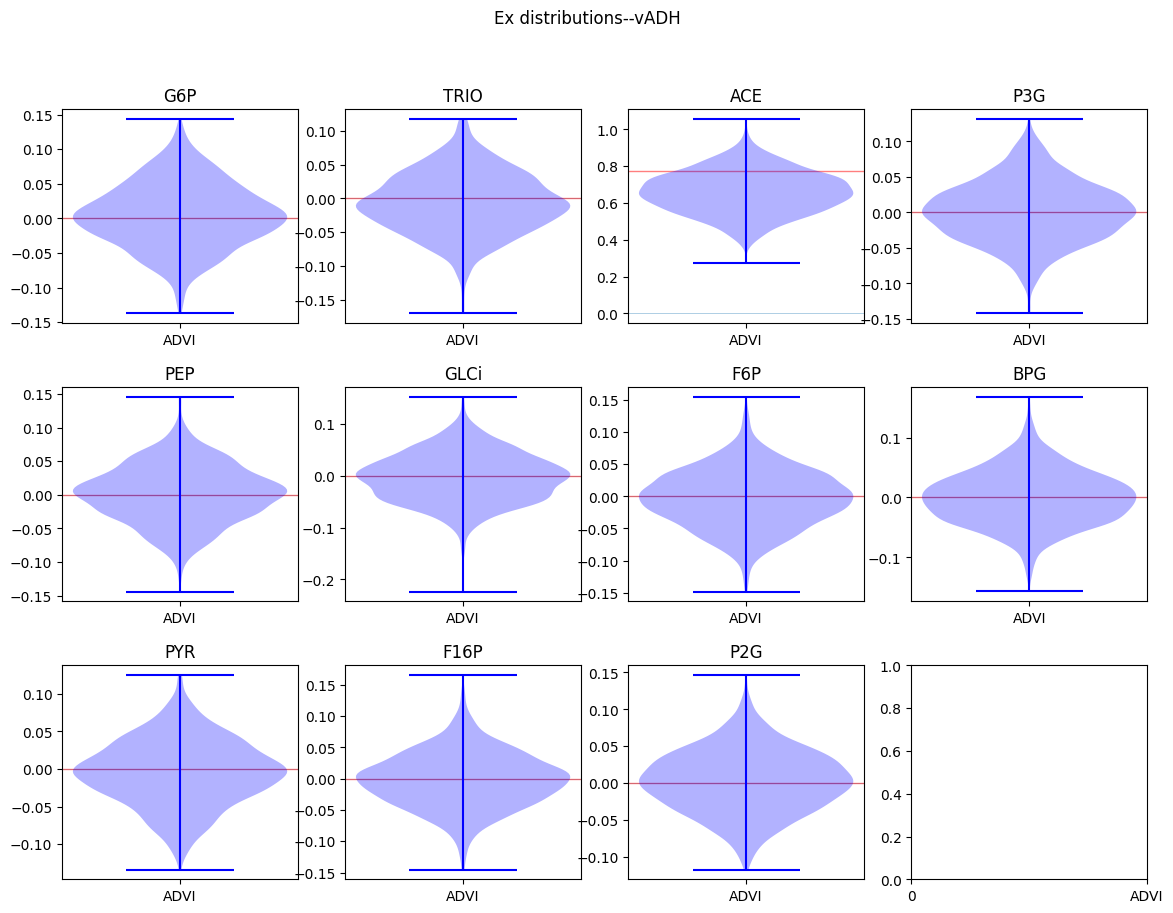

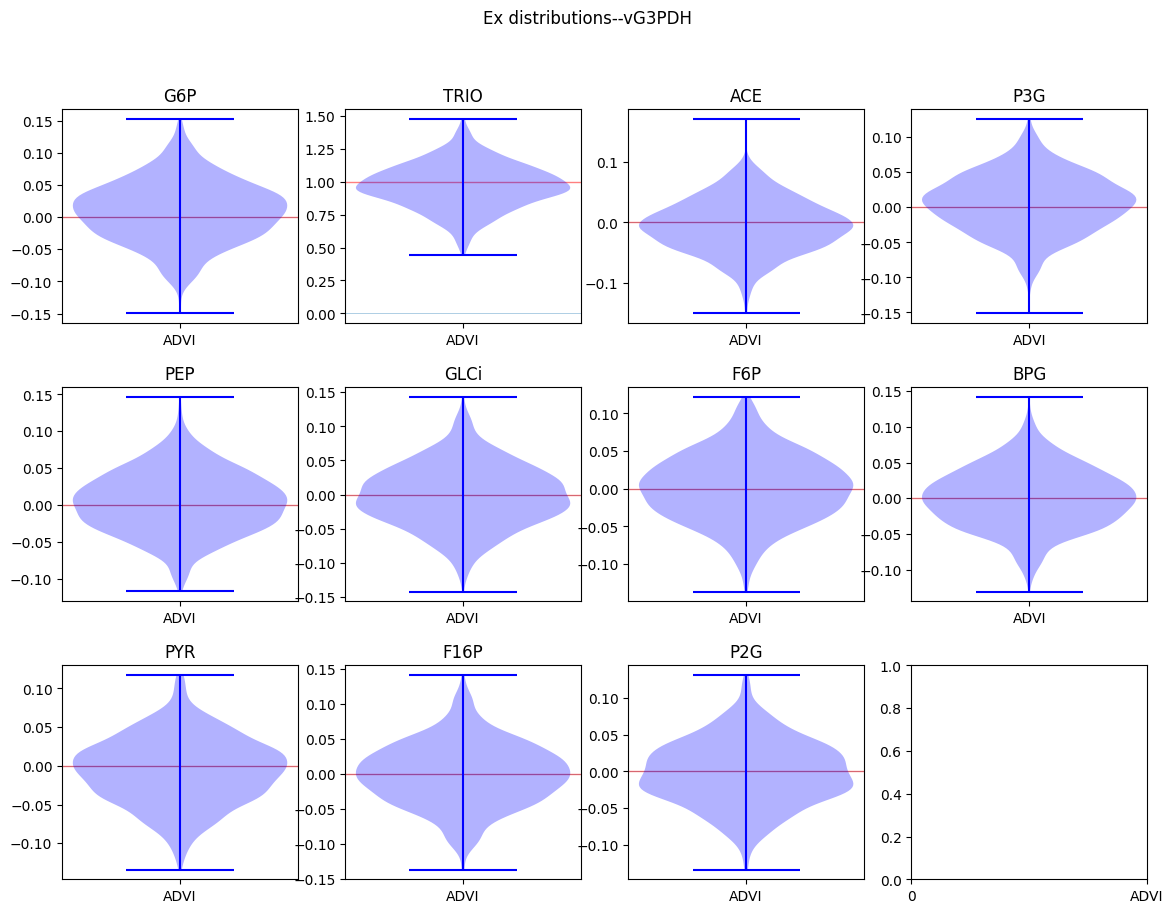

In [8]:
colors = ['blue', 'green', '#fa8602', 'magenta', '#07f53b', '#2312b8']

for i,rxn in enumerate(r.getReactionIds()): #['vADH']
    
    fig, ax = plt.subplots(3,4, figsize = (14,10))
    ii=-1
    
    fig.suptitle(f'Ex distributions--{rxn}\n')
    # plt.setp(ax, xticks=range(3), xticklabels=[0,'MCMC', 'ADVI'])
    plt.setp(ax, xticks=range(2), xticklabels=[0, 'ADVI'])
    plt.subplots_adjust(hspace=0.3)
    
    for j,met in enumerate(r.getFloatingSpeciesIds()): # ['TRIO'])
        if j%4==0:
            ii += 1

        met_traces=[]
        for trace in [Ex_advi.transpose(1,2,0)]: # Ex.transpose(1, 2, 0),
            met_traces.append(trace[i,j,:]) 
            
        met_traces = np.array(met_traces).T

        plots = ax[ii, j%4].violinplot(met_traces)

        # Set the color of the violin patches
        for pc, color in zip(plots['bodies'], colors):
            pc.set_facecolor(color)
        plots['cbars'].set_colors(colors)
        plots['cmaxes'].set_colors(colors)
        plots['cmins'].set_colors(colors)
        
        ax[ii, j%4].axhline(0, linewidth=0.5, zorder=0, alpha=0.5)
        ax[ii, j%4].axhline(r.getScaledElasticityMatrix()[i,j], linewidth=1, zorder=0, alpha=0.5,color='red')
        ax[ii, j%4].set_title(met)
    
    # fig.delaxes(ax[3,2]) 
    # fig.delaxes(ax[3,3]) 

## Backcalculating to check if there are multiple elasticity solutions

In [9]:
med_Ex_advi = np.median(Ex_advi, axis=0)
med_Ey_advi = np.median(Ey_advi, axis=0)

In [11]:
BMCA_obj.vn
# d_df is the flux calculated using the Bayesian inference ADVI POSTERIORS for elasticity
advi_vn = BMCA_obj.en.values * (np.ones(BMCA_obj.en.T.shape) + med_Ex_advi@(BMCA_obj.xn.T) + med_Ey_advi@(BMCA_obj.yn.T)).T
advi_vn_df = pd.DataFrame(advi_vn)
advi_vn_df.columns = BMCA_obj.vn.columns #r.getReactionIds()
# advi_vn_df

Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

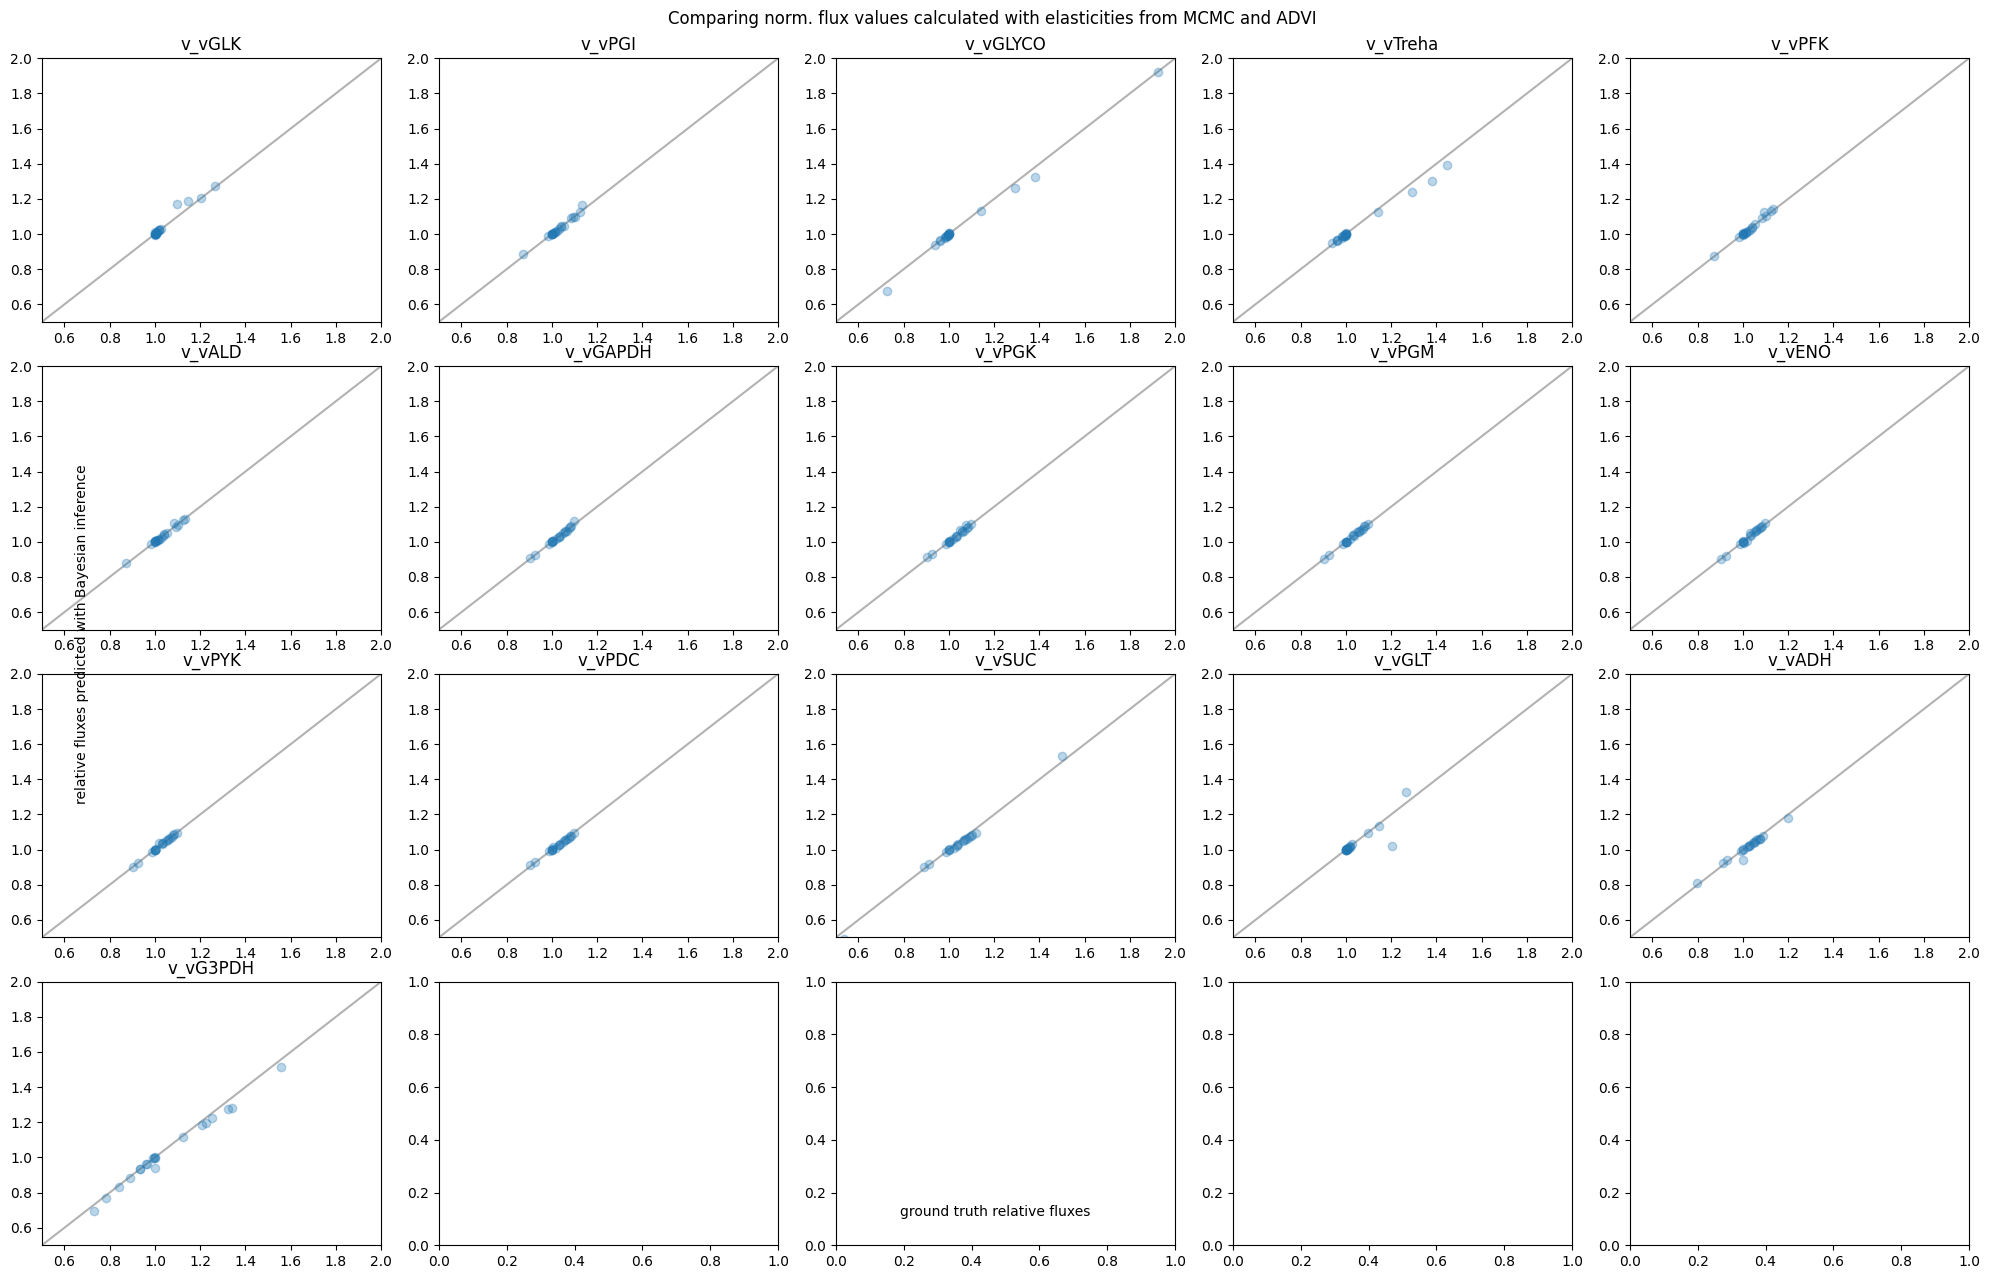

In [12]:
fig, axs = plt.subplots(4,5, figsize=(20, 13)) 
idx_starter = -1

fig.suptitle('Comparing norm. flux values calculated with elasticities from MCMC and ADVI \n')
fig.tight_layout()

lims = [0.5,2]

for i,col in enumerate(advi_vn_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    # axs[idx_starter, i%5].scatter(BMCA_obj.vn[col], MCMC_vn_df[col], alpha=0.3)
    axs[idx_starter, i%5].scatter(BMCA_obj.vn[col], advi_vn_df[col], alpha=0.3)
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

### Subtracting the vn values from fluxes calculated using elasticity posteriors

In [13]:
advi_dif = advi_vn_df-BMCA_obj.vn
# advi_dif[advi_dif < 1E-1] = 0 
advi_dif

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.071333,-0.003962,-0.006602,-0.015595,0.003359,-0.001605,0.001027,-0.001429,0.000881,0.003222,0.001455,-0.003930,-0.007465,-0.007112,-0.005386,-0.008988
2,0.002437,0.032593,-0.003438,0.008115,0.008705,-0.002222,0.005819,-0.003133,0.003699,0.006788,0.001575,-0.007463,-0.019706,0.000659,-0.016572,-0.056757
3,0.003837,0.001310,-0.002333,0.001644,-0.000471,0.000650,0.000037,0.000603,-0.000392,-0.000601,-0.000109,0.000803,0.001875,-0.001655,0.001780,0.000106
4,0.039979,0.015572,-0.050423,-0.054858,-0.000033,0.007653,0.004260,0.008428,-0.000768,-0.004256,-0.000567,0.006092,0.011411,-0.011695,0.013485,-0.037210
5,0.003048,0.006751,0.000690,0.007253,0.034947,-0.005724,0.003859,0.002250,0.002474,0.007189,0.001003,-0.006598,-0.012303,0.002419,-0.010068,-0.029737
6,0.002434,0.004941,0.002007,0.001384,0.004923,0.023177,0.001400,-0.000171,-0.000843,0.005437,0.000056,-0.003434,-0.013287,-0.001946,-0.008555,-0.025890
7,-0.000010,0.002852,0.002388,0.005398,-0.003158,0.000051,0.019390,0.000087,0.001969,0.005619,-0.002115,-0.006402,-0.024814,0.001181,-0.012747,-0.018272
8,0.001502,0.000403,-0.000297,0.003248,-0.006391,-0.002851,0.006825,0.021816,-0.002289,0.006530,-0.001607,-0.006698,-0.016591,-0.002629,-0.008760,-0.008373
9,-0.002171,-0.001554,-0.001126,-0.003502,-0.002723,-0.004538,-0.001173,0.016332,0.003879,0.006256,-0.000522,-0.004529,-0.011549,-0.002401,-0.006318,-0.006438


## Calculating FCCs

In [14]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [15]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return CCC.eval(), FCC


### Negative predictions

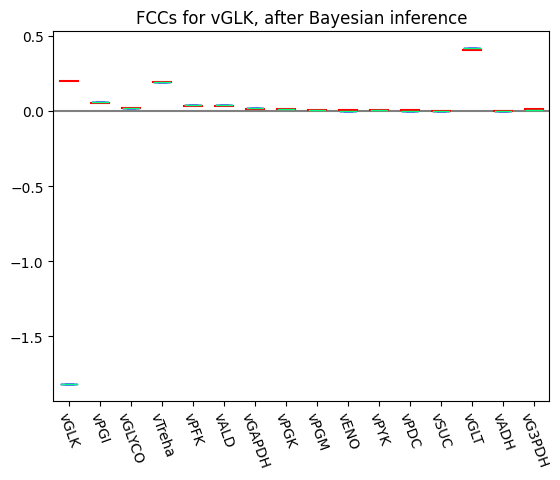

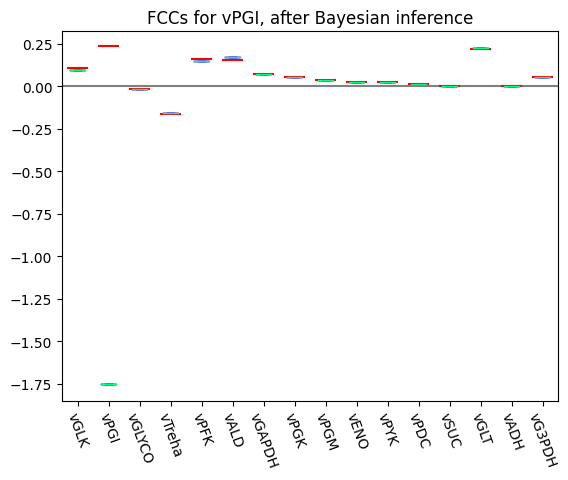

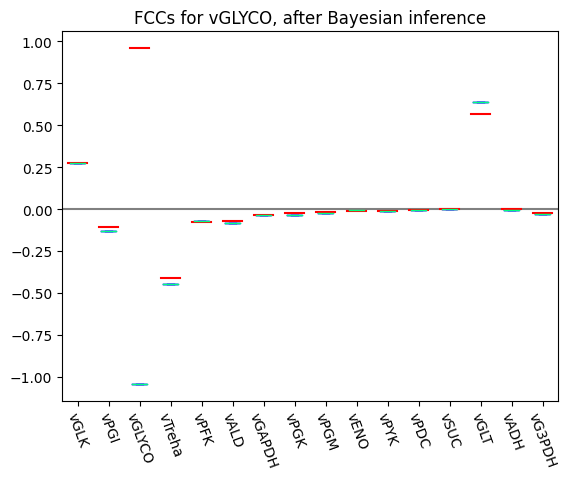

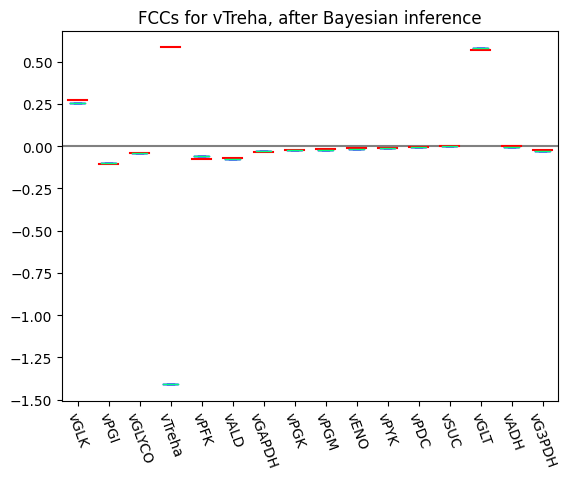

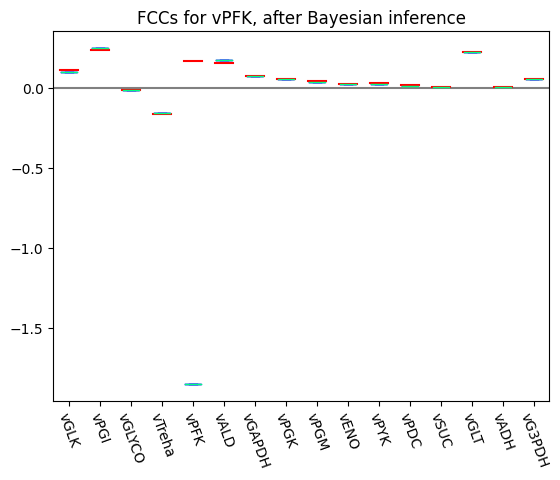

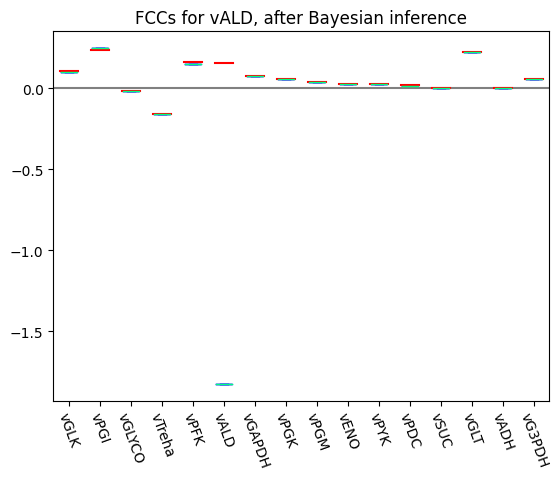

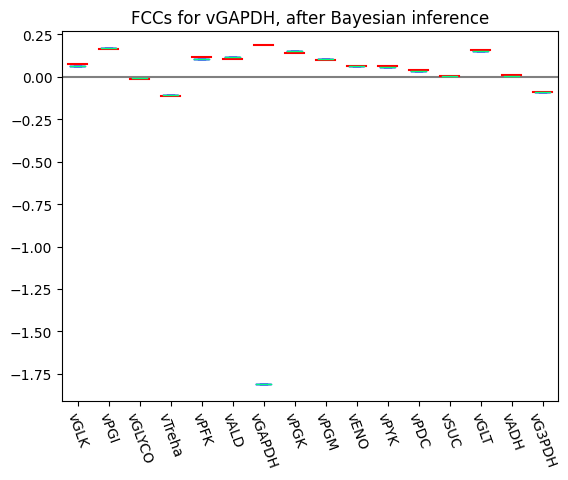

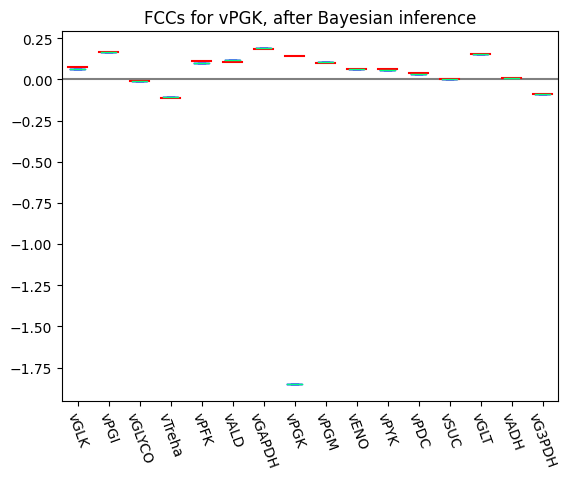

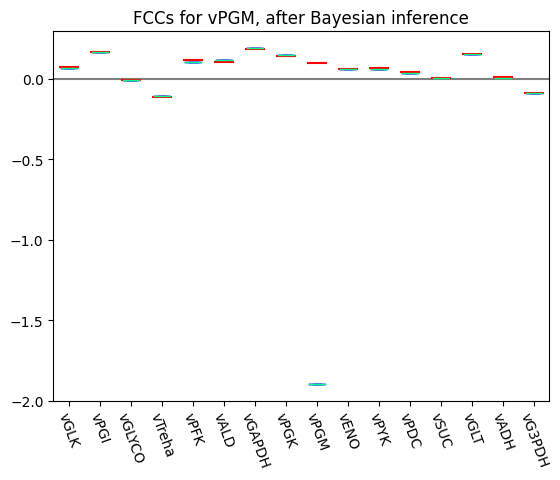

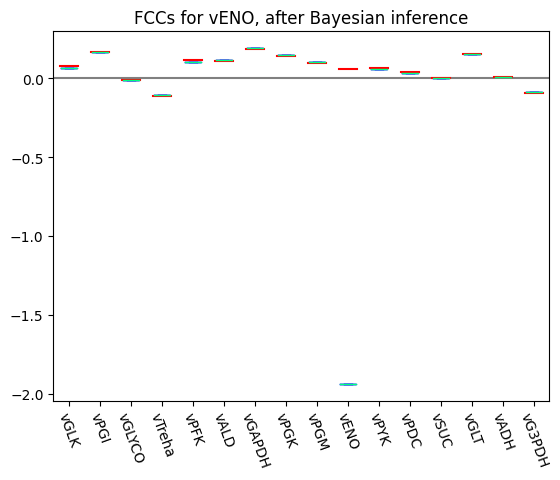

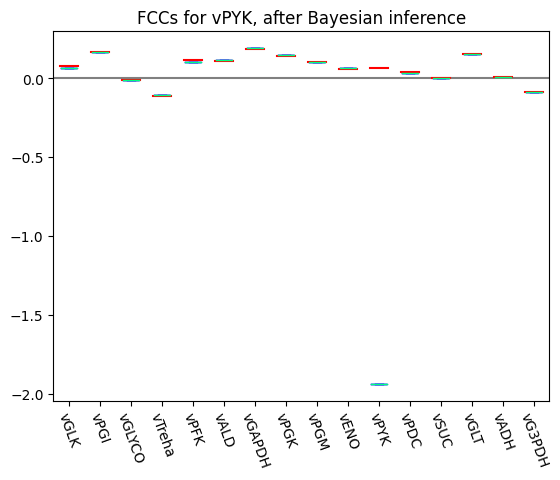

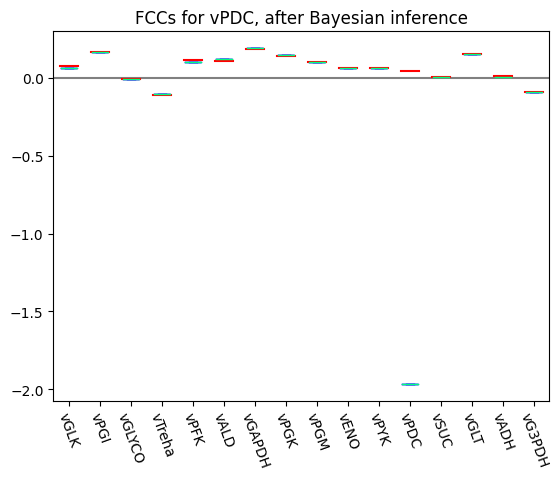

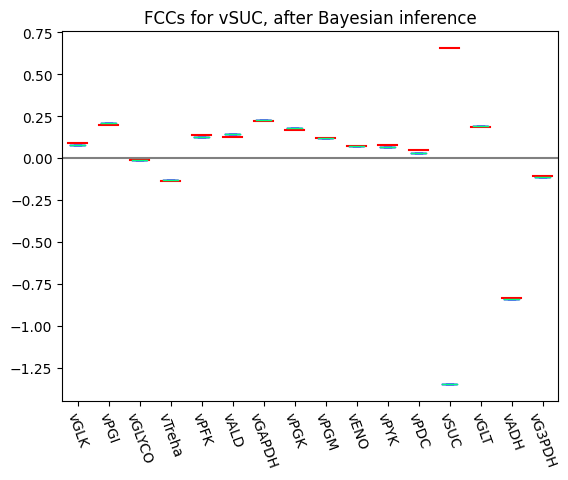

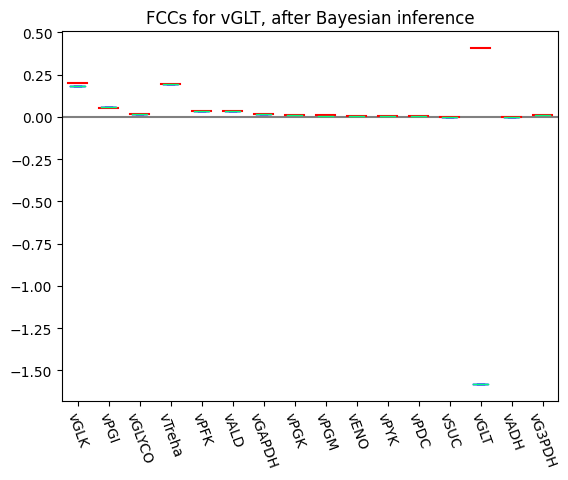

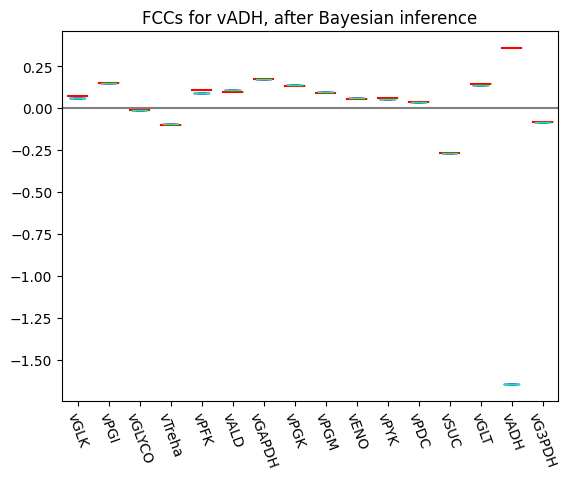

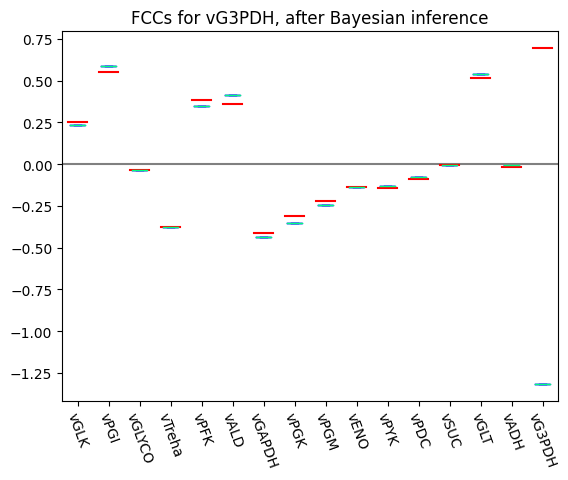

In [16]:
postCCC, postFCC = estimate_CCs(BMCA_obj, med_Ex_advi)
for i,rxnID in enumerate(r.getReactionIds()):
    FCCs = -pd.DataFrame(postFCC[:,i,:], columns=r.getReactionIds())
    # FCCs = pd.DataFrame(postFCC[:,i,:], columns=r.getReactionIds())

    FCCs.plot(kind='box', colormap='winter')
    plt.title(f'FCCs for {rxnID}, after Bayesian inference')
    plt.axhline(0, c='gray')

    for i,val in enumerate(gtFCC.loc[rxnID]): # .sort_index()
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[rxnID]), # From the left
                xmax = (i+0.8)/len(gtFCC[rxnID]), 
                c='red') # To the right
    plt.xticks(rotation=-70)
# plt.ylim((-1,3))

## Evaluating FCC ranking

In [17]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')
# gtFCC_rankings

In [19]:
postFCC_med=pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
# m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
postFCC_med = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=gtFCC.columns, index=gtFCC.index)
postFCC_med_rankings= postFCC_med.rank(axis=1, ascending=False, na_option='keep')
# postFCC_med_rankings

In [20]:
for i in r.getReactionIds():
    a = gtFCC_rankings.loc[i].values
    b = postFCC_med_rankings.loc[i].values
    spcorr = stats.spearmanr(a,b,nan_policy='omit')
    print(i, spcorr)

vGLK SpearmanrResult(correlation=0.9857142857142855, pvalue=1.9290948746066845e-11)
vPGI SpearmanrResult(correlation=0.9785714285714284, pvalue=2.6454560123987495e-10)
vGLYCO SpearmanrResult(correlation=0.9928571428571429, pvalue=2.1681214863290813e-13)
vTreha SpearmanrResult(correlation=0.9714285714285713, pvalue=1.6870764886091287e-09)
vPFK SpearmanrResult(correlation=0.9892857142857141, pvalue=2.9989342571552654e-12)
vALD SpearmanrResult(correlation=0.9892857142857141, pvalue=2.9989342571552654e-12)
vGAPDH SpearmanrResult(correlation=0.9714285714285713, pvalue=1.6870764886091287e-09)
vPGK SpearmanrResult(correlation=0.9714285714285713, pvalue=1.6870764886091287e-09)
vPGM SpearmanrResult(correlation=0.982142857142857, pvalue=8.15733350897873e-11)
vENO SpearmanrResult(correlation=0.9749999999999999, pvalue=7.14370596522927e-10)
vPYK SpearmanrResult(correlation=0.9749999999999999, pvalue=7.14370596522927e-10)
vPDC SpearmanrResult(correlation=0.9714285714285713, pvalue=1.687076488609128